# Feature Importance
One of the benefits to decision trees is that their results are fairly interpretable in that they allow for estimation of the relative importance of each feature.

There are many approaches that have been suggested for quantifying importances. The `scikit-learn` implementation of the random forest quantifies these importances using the Gini impurity. For `SPORF` and `MORF`, we use a projection forest specific metric to quantify feature importance by computing the normalized count of the number of times a feature $k$ was used in projections across the ensemble of decision trees.

Specifically, consider our forest $\mathcal{T}$ to be a collection of decision trees $\{T_i\}_{i=1}^n$, where each decision tree $T_i \in \mathcal{T}$ is composed of many nodes $j$. Let $\mathcal{A}$ be the set of unique atoms across all nodes and all trees in our forest. For each feature $k$, its importance $\pi_k$ is computed as the number of times an atom assigns it a nonzero weighting, followed by a normalization of $|\mathcal{A}|$.
$$
\pi_k = \frac{1}{|\mathcal{A}|} \sum_{T_i \in \mathcal{T}} \sum_{j \in T_i} \mathbb{I}(a_{jk} \not= 0)
$$

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from oblique_forests.tree.oblique_tree import ObliqueTreeClassifier as OTC
from oblique_forests.sporf import ObliqueForestClassifier as SPORF
from oblique_forests.morf import Conv2DObliqueForestClassifier as MORF

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

mpl.rcParams.update({
    "axes.titlesize": "xx-large",
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "xtick.bottom": False,
    "ytick.left": False,
    "image.cmap": "inferno",
    "image.aspect": 1
})

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Digits Dataset
We visualize feature importances identified by `RF`, `SPORF`, and `MORF` on a subset of the MNIST dataset. We only consider threes and fives and use 100 8x8 images from each class.

In [2]:
from sklearn.datasets import load_digits

images, labels = load_digits(return_X_y=True)
print(images.shape, labels.shape)

(1797, 64) (1797,)


In [3]:
# Get 100 samples of 3s and 5s
num = 100
threes = np.where(labels == 3)[0][:num]
fives = np.where(labels == 5)[0][:num]
idx = np.concatenate((threes, fives))

# Subset train data
X = images[idx]
y = labels[idx]

# Apply random shuffling
permuted_idx = np.random.permutation(len(idx))
X = X[permuted_idx]
y = y[permuted_idx]

print(X.shape, y.shape)

(200, 64) (200,)


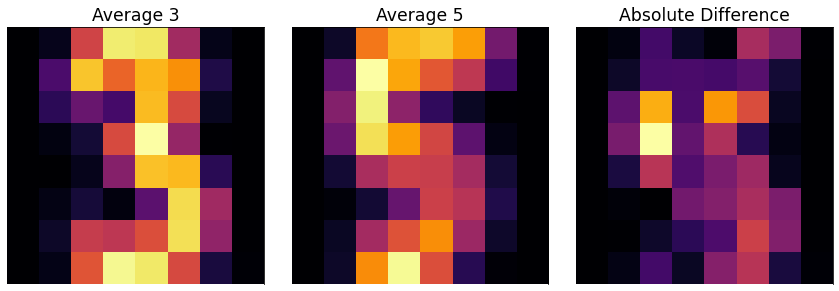

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
avg_3 = images[threes].mean(axis=0).reshape(8, 8)
avg_5 = images[fives].mean(axis=0).reshape(8, 8)
diff = np.abs(avg_3 - avg_5)

axs[0].imshow(avg_3)
axs[0].set_title("Average 3")

axs[1].imshow(avg_5)
axs[1].set_title("Average 5")

axs[2].imshow(diff)
axs[2].set_title("Absolute Difference")
for ax in axs:
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
fig.tight_layout()

In [5]:
clfs = [
    RandomForestClassifier(random_state=0),
    SPORF(random_state=0),
    MORF(random_state=0, image_height=8, image_width=8)
]
for clf in clfs:
    clf.fit(X, y)

In [6]:
def rename_clf(clf):
    if isinstance(clf, RandomForestClassifier):
        return "RF"
    elif isinstance(clf, SPORF):
        return "SPORF"
    elif isinstance(clf, MORF):
        return "MORF"

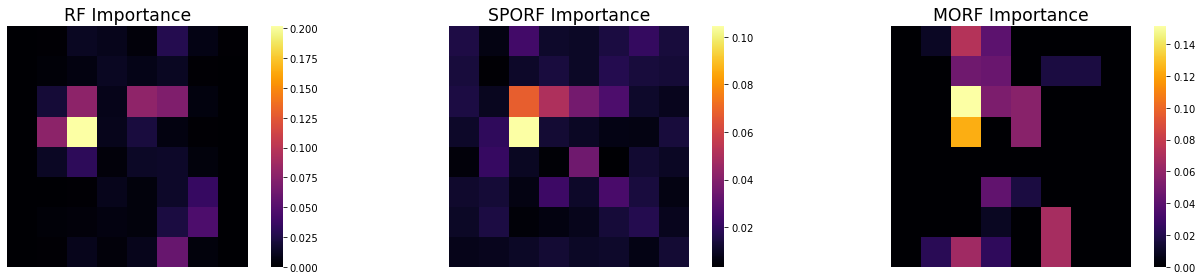

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(19, 4))

for clf, ax in zip(clfs, axs):
    importances = clf.feature_importances_
    sns.heatmap(importances.reshape(8, 8), cmap='inferno', square=True, ax=ax)
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
    ax.set_title(f"{rename_clf(clf)} Importance")
fig.tight_layout();

## MNIST Dataset
We visualize feature importances identified by `RF`, `SPORF`, and `MORF` on a subset of the MNIST dataset. We only consider threes and fives and use 100 28x28 images from each class.

In [8]:
# from sklearn.datasets import fetch_openml
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [13]:
# Get 100 samples of 3s and 5s
num = 100
threes = np.where(y_train == 3)[0][:num]
fives = np.where(y_train == 5)[0][:num]
train_idx = np.concatenate((threes, fives))

# Subset train data
Xtrain = X_train[train_idx]
ytrain = y_train[train_idx]

# Apply random shuffling
permuted_idx = np.random.permutation(len(train_idx))
Xtrain = Xtrain[permuted_idx]
ytrain = ytrain[permuted_idx]

# Subset test data
test_idx = np.where(y_test == 3)[0]
Xtest = X_test[test_idx]
ytest = y_test[test_idx]

print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape, sep='\n')

(200, 28, 28)
(200,)
(1010, 28, 28)
(1010,)


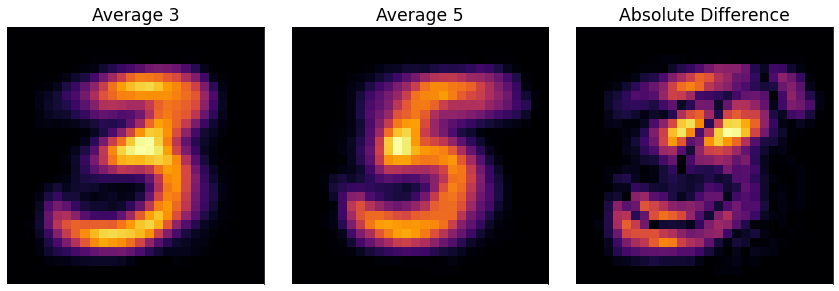

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
avg_3 = X_train[threes].mean(axis=0)
avg_5 = X_train[fives].mean(axis=0)
diff = np.abs(avg_3 - avg_5)

axs[0].imshow(avg_3)
axs[0].set_title("Average 3")

axs[1].imshow(avg_5)
axs[1].set_title("Average 5")

axs[2].imshow(diff)
axs[2].set_title("Absolute Difference")
for ax in axs:
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
fig.tight_layout()

In [ ]:
# morf = MORF(random_state=0, image_height=28, image_width=28)
# morf.fit(X, y)

In [21]:
clf = RandomForestClassifier(random_state=0)
clf.fit(Xtrain.reshape(Xtrain.shape[0], -1), ytrain)

RandomForestClassifier(random_state=0)

In [22]:
def rename_clf(clf):
    if isinstance(clf, RandomForestClassifier):
        return "RF"
    elif isinstance(clf, SPORF):
        return "SPORF"
    elif isinstance(clf, MORF):
        return "MORF"

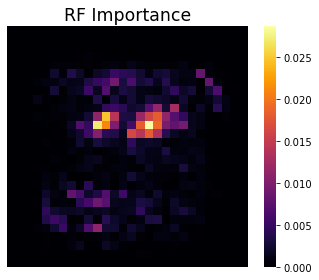

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))
importances = clf.feature_importances_
sns.heatmap(importances.reshape(28, 28), cmap='inferno', square=True)
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
ax.set_title(f"{rename_clf(clf)} Importance")
fig.tight_layout();

In [28]:
clf = SPORF(n_estimators=500, random_state=0)
clf.fit(Xtrain.reshape(Xtrain.shape[0], -1), ytrain)

ObliqueForestClassifier(n_estimators=500, random_state=0)

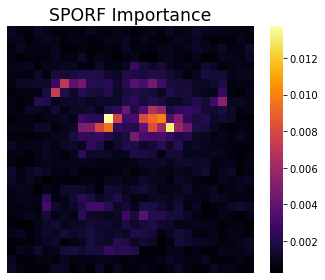

In [29]:
fig, ax = plt.subplots(figsize=(5, 4))
importances = clf.feature_importances_
sns.heatmap(importances.reshape(28, 28), cmap='inferno', square=True)
ax.tick_params(
    axis="both",
    which="both",
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
ax.set_title(f"{rename_clf(clf)} Importance")
fig.tight_layout();

In [ ]:
# XXX: MORF fits too slowly
clfs = [
    RandomForestClassifier(random_state=0),
    SPORF(random_state=0),
    MORF(random_state=0, image_height=28, image_width=28)
]
for clf in clfs:
    clf.fit(X, y)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(19, 4))

for clf, ax in zip(clfs, ax):
    importances = clf.feature_importances_
    sns.heatmap(importances.reshape(28, 28), cmap='inferno', square=True, ax=ax)
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
    ax.set_title(f"{rename_clf(clf)} Importance")
fig.tight_layout();